<a href="https://colab.research.google.com/github/Emmnmm/STA365HW9/blob/main/hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1

In [127]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import tensorflow as tf
from scipy.stats import norm, expon, lognorm
import scipy.stats as stats

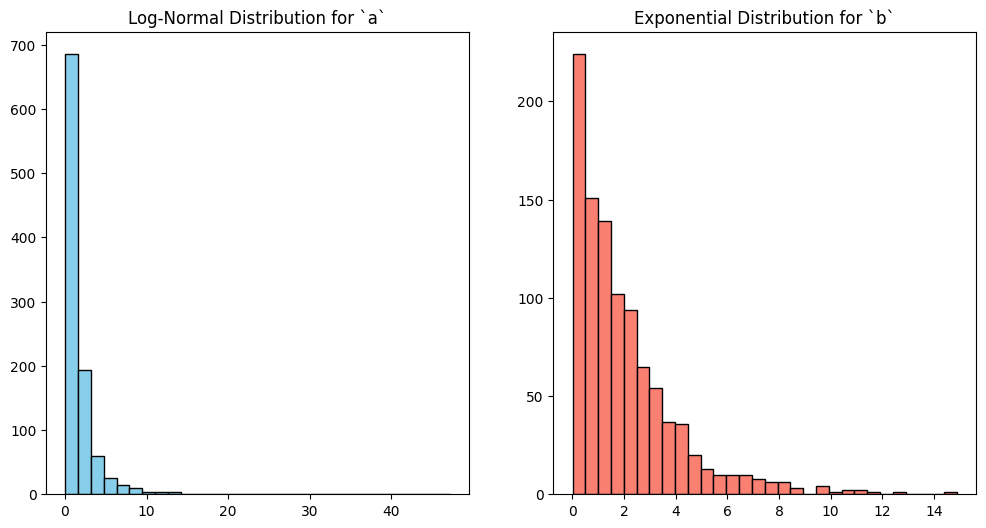

In [39]:

np.random.seed(42)

# Generate synthetic non-normal data
n_samples = 1000
a = np.random.lognormal(mean=0, sigma=1, size=n_samples)  # Log-normal for `a`
b = np.random.exponential(scale=2, size=n_samples)  # Exponential for `b`

# Plot the data to check the distributions
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(a, bins=30, color='skyblue', edgecolor='black')
plt.title("Log-Normal Distribution for `a`")
plt.subplot(1, 2, 2)
plt.hist(b, bins=30, color='salmon', edgecolor='black')
plt.title("Exponential Distribution for `b`")
plt.show()



In [67]:
# Define the first pass model
with pm.Model() as marginal_model:
    # Define priors for the marginals
    a_mu = pm.Normal("a_mu", mu=0, sigma=1)
    a_sigma = pm.Exponential("a_sigma", lam=1.0)
    b_scale = pm.Exponential("b_scale", lam=1.0)

    # Likelihood for observed data
    pm.Normal("a", mu=a_mu, sigma=a_sigma, observed=a)
    pm.Exponential("b", lam=1/b_scale, observed=b)

    # Sample from the model to estimate the marginal parameters
    marginal_idata = pm.sample(random_seed=42)

a_mu_post = marginal_idata.posterior["a_mu"].mean().item()
a_sigma_post = marginal_idata.posterior["a_sigma"].mean().item()
b_scale_post = marginal_idata.posterior["b_scale"].mean().item()

a_uniform = norm.cdf(a, loc=a_mu_post, scale=a_sigma_post)
b_uniform = expon.cdf(b, scale=b_scale_post)



Output()

In [63]:
# Define the second pass copula model
coords = {"obs_id": np.arange(len(a_uniform)), "param": ["a", "b"], "param_bis": ["a", "b"]}

with pm.Model(coords=coords) as copula_model:
    # Define the prior for the correlation matrix of the copula (using LKJ prior)
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,  # Hyperparameter for correlation strength
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True
    )

    # Compute the covariance matrix from the Cholesky decomposition
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood for the copula model (multivariate normal with the computed covariance)
    pm.MvNormal("N", mu=0.0, cov=cov, observed=np.column_stack((a_uniform, b_uniform)), dims=("obs_id", "param"))

    # Sample from the posterior to estimate the copula parameters
    copula_idata = pm.sample(
    random_seed=42,     # Random seed for reproducibility
    tune=2000,          # Number of tuning steps (burn-in)
    target_accept=0.9,  # Target acceptance rate (default is 0.8)
    cores=1             # Number of cores for parallel sampling
)



Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

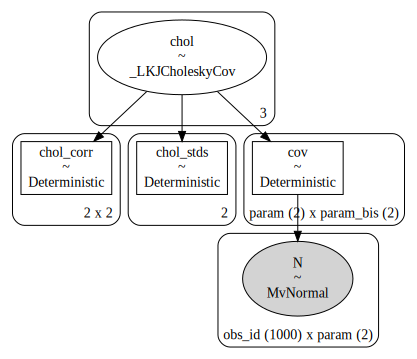

In [72]:
pm.model_graph.model_to_graphviz(copula_model)

In [88]:
# Ensure that the transformation and inverse transformation are consistent with the original data scale
a_uniform_samples = norm.cdf(copula_samples[0])  # Convert back to [0,1] scale
b_uniform_samples = norm.cdf(copula_samples[1])

# Now transform to the original data scale
a_transformed = lognorm.ppf(a_uniform_samples, s=a_sigma_post, scale=np.exp(a_mu_post))  # lognorm to original scale
b_transformed = expon.ppf(b_uniform_samples, scale=b_scale_post)  # Exponential to original scale


Q1.3: Describe what a copula is and how the two verions of code implement it...

A copula is  used to model and analyze the dependence structure between multiple random variables, separately from their marginal distributions. It works by using each varible's CDF to transform them into a uniform distribution.Once the data is in uniform space , their dependance is modeled using a copula model to capture how the varibles interact. And once the model is fitted , we generate new samples and transform them back using inverse cdfs.

The two pass method from pymc model the dependence structure first  and then modelthe marginals whereas the for provided code marginal distributions and their dependencies are modeled together in a single step. The likelihood is directly defined by using pm.MvNormal and the transformations for each variable are incorporated as part of the model. So while a two pass model would be better at flexibilty using the one step method should be better as it simplifies the model and avoids the extra steps of transforming the copula back to the observed scale making the model more efficent and easier to implement .

Q1.4 :Describe how to use this to create arbitrary multivariate GLM regressions

In the two-pass method for creating a multivariate Generalized Linear Model (GLM), the modeling process is split into two distinct steps. In the first pass, we model the copula and it will captures how the variables are correlated, and generating the covariance matrix that describes these relationships. In the second pass, we model the marginal distributions for each variable independently (e.g., Log-Normal, Exponential). After the copula samples are generated, they are transformed back to the original scale using inverse CDF transformations for each marginal.
On the other hand, the one-pass method combines the modeling of the dependence structure and the marginals into a single step. In this approach, we just define a multivariate likelihood that incorporates both the copula and the marginal distributions together. The dependence structure is modeled directly in the covariance matrix, and the marginals are treated as part of the joint distribution. By modeling both elements simultaneously, this approach avoids the need for transformations, simplifying the model. The parameters of the GLM are estimated directly from the joint distribution. Making it much more simple when implementing.

# Q2

In [91]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt


In [101]:
# Set the random seed for reproducibility
np.random.seed(42)

# Define number of observations and predictors
n = 100   # Number of observations
p = 5     # Number of predictors

# Generate random predictors (X)
X = np.random.randn(n, p)

# Define true coefficients for the regression
true_beta = np.array([2, 0, -1, 0, 0])

# Generate the response variable (y) with some noise
y = X @ true_beta + np.random.randn(n)




Output()

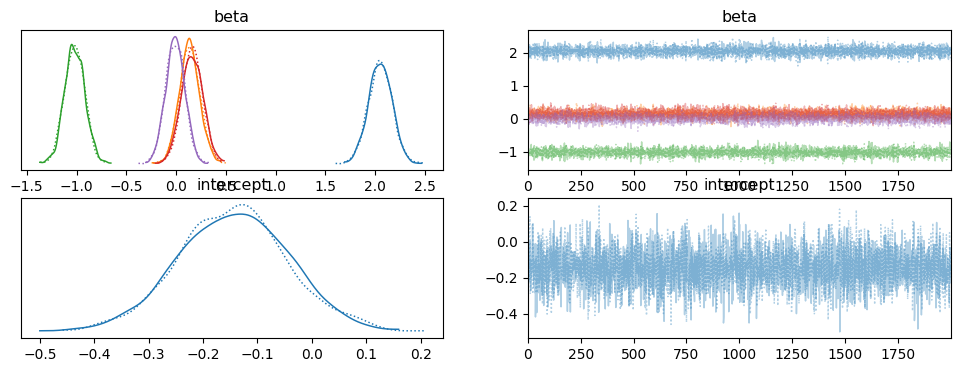

In [102]:
with pm.Model() as model_diffuse:
    # Priors for the coefficients (diffuse normal prior)
    beta = pm.Normal('beta', mu=0, sigma=100, shape=p)

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=100)

    # Likelihood (regression model)
    mu = intercept + pm.math.dot(X, beta)
    likelihood = pm.Normal('y', mu=mu, sigma=1, observed=y)

    # Sampling using MCMC
    trace_diffuse = pm.sample(2000, return_inferencedata=True)


az.plot_trace(trace_diffuse)
plt.show()


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeW

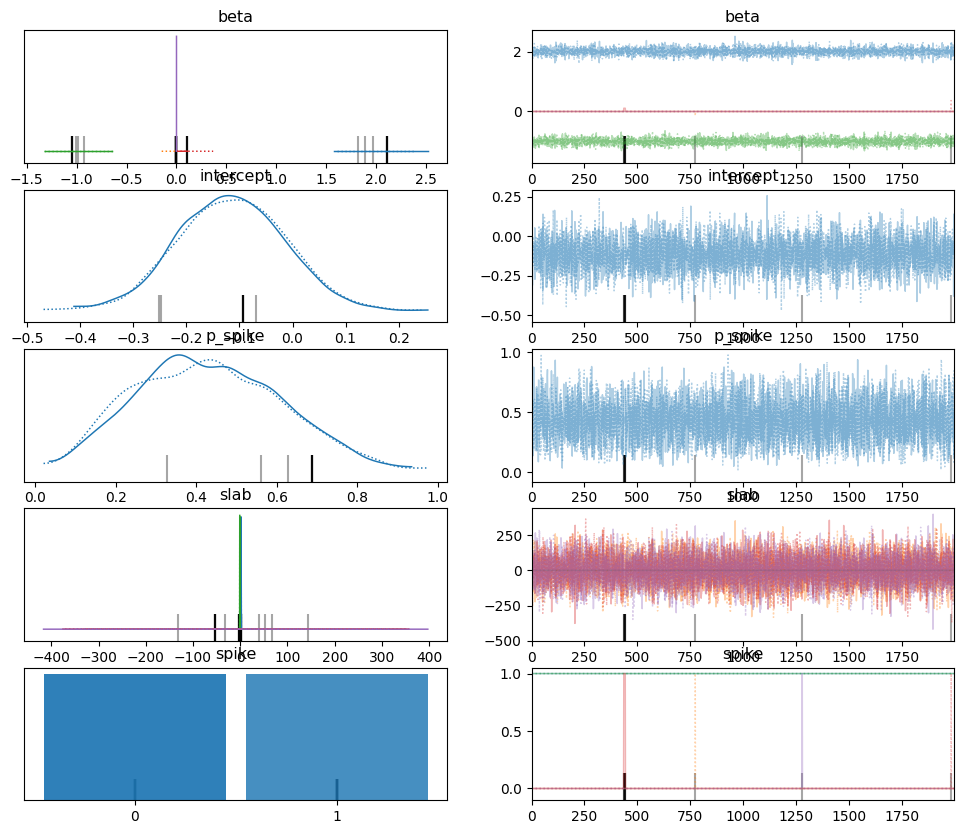

In [103]:
with pm.Model() as spike_and_slab:

    # Hyperparameters for the spike-and-slab prior
    p_spike = pm.Beta('p_spike', alpha=1, beta=1)  # Probability of selecting the slab (spike)

    # Spike (Bernoulli) and Slab (Normal) for each coefficient
    spike = pm.Bernoulli('spike', p=p_spike, shape=p)  # Bernoulli for the "spike" part
    slab = pm.Normal('slab', mu=0, sigma=100, shape=p)  # Normal for the "slab" part

    # Combine spike and slab to get the regression coefficients (beta)
    beta = pm.Deterministic('beta', spike * slab)  # If spike=0, beta=0; if spike=1, beta is from the slab

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=100)

    # Likelihood (regression model)
    mu = intercept + pm.math.dot(X, beta)
    likelihood = pm.Normal('y', mu=mu, sigma=1, observed=y)

    # Sampling using MCMC
    idata = pm.sample(2000, return_inferencedata=True)

# Summarize and plot the results

az.plot_trace(idata)
plt.show()

In [119]:
az.summary(idata, hdi_prob=0.95, var_names=["beta"])


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.013,0.111,1.803,2.241,0.001,0.002,5493.0,3634.0,1.0
beta[1],-0.000,0.002,-0.000,0.000,0.000,0.001,4008.0,4000.0,1.0
beta[2],-1.002,0.103,-1.213,-0.812,0.001,0.002,5541.0,3205.0,1.0
beta[3],0.000,0.008,-0.000,-0.000,0.000,0.003,578.0,555.0,1.0
beta[4],-0.000,0.000,0.000,-0.000,0.000,0.000,4008.0,4000.0,1.0


In [117]:
az.summary(trace_diffuse, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.051,0.118,1.817,2.280,0.001,0.002,6252.0,3254.0,1.0
beta[1],0.135,0.103,-0.071,0.338,0.002,0.002,4241.0,3008.0,1.0
beta[2],-1.020,0.102,-1.205,-0.814,0.001,0.002,5656.0,3092.0,1.0
beta[3],0.160,0.106,-0.041,0.371,0.001,0.002,5737.0,2927.0,1.0
beta[4],-0.009,0.096,-0.191,0.186,0.001,0.002,5801.0,2811.0,1.0
intercept,-0.145,0.101,-0.337,0.065,0.002,0.002,4302.0,3306.0,1.0


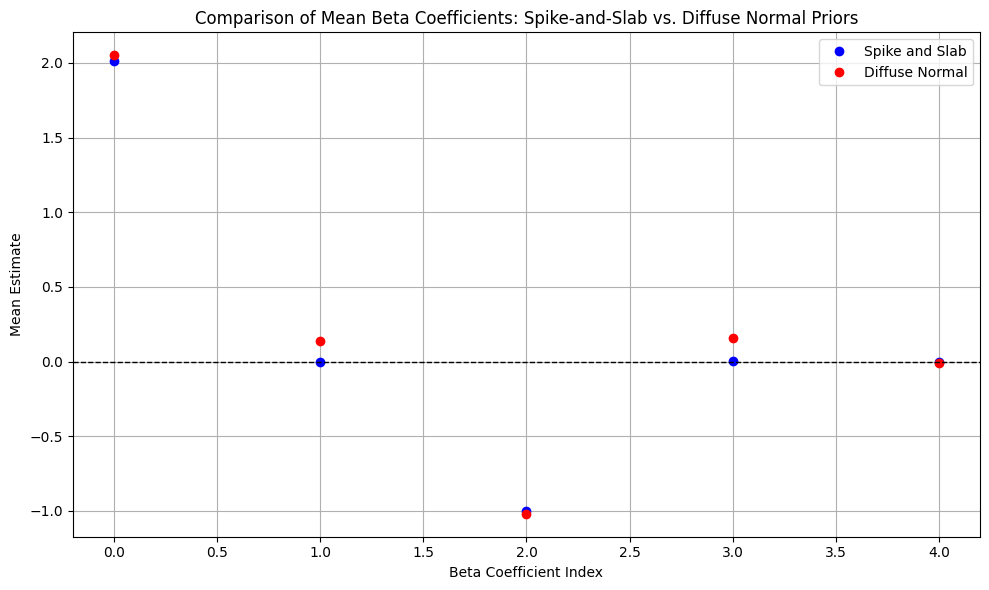

In [120]:
# Extract the beta coefficients' means from both models
beta_spike_slab_mean = idata.posterior['beta'].mean(dim=["chain", "draw"]).values
beta_diffuse_mean = trace_diffuse.posterior['beta'].mean(dim=["chain", "draw"]).values

# Create a plot
plt.figure(figsize=(10, 6))

# Plot for the spike-and-slab model
plt.plot(beta_spike_slab_mean, 'o', label="Spike and Slab", color='blue')

# Plot for the diffuse normal model
plt.plot(beta_diffuse_mean, 'o', label="Diffuse Normal", color='red')

# Formatting the plot
plt.axhline(0, color='black', lw=1, linestyle='--')  # Zero line for reference
plt.xlabel('Beta Coefficient Index')
plt.ylabel('Mean Estimate')
plt.title('Comparison of Mean Beta Coefficients: Spike-and-Slab vs. Diffuse Normal Priors')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

The spike component of the spike-and-slab prior pushes irrelevant coefficients in the direction of zero. The model is likely to reduce a coefficient to zero if the data doesn't support it being significant. As a result, coefficients that are deemed irrelevant -> in our model, beta[1], beta[3], and beta[4]have estimates that are zero, which is consistent with the prior's strong preference for zero in the absence of evidence.
On the other hand, the diffuse normal prior is less aggressive and allows greater variability in the coefficient estimates, even though it still shrinks coefficients toward zero. This means that non-zero values can still be assigned to irrelevant coefficients in the diffuse normal prior model. Because of this, we observe non-zero estimates for all betas in our model, even those whose relevance may not be well supported by data.

It should be noted that the larger the n , the more time need to sample due to the increase in data needed to be processed by the model , increase to the number of random variables will also the increase the computational cost as it increases the dimensionality of the model and the larger the columns in the design matrix , the more computational cost is needed when calculating liklihood .

# Q3

In [128]:
with pm.Model() as horseshoe:
    # Global scale (lambda) with a Half-Cauchy prior
    lambda_ = pm.HalfCauchy('lambda', beta=1)

    # Local scales for each coefficient with a Half-Cauchy prior
    tau = pm.HalfCauchy('tau', beta=1, shape=p)  # Half-Cauchy prior for each coefficient

    # Coefficients for the predictors (beta), with shrinkage from lambda and tau
    beta = pm.Normal('beta', mu=0, sigma=lambda_ * tau, shape=p)

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=100)

    # Likelihood (regression model)
    mu = intercept + pm.math.dot(X, beta)
    likelihood = pm.Normal('y', mu=mu, sigma=1, observed=y)

    # Sampling using MCMC
    idata_horseshoe = pm.sample(1000, target_accept=0.9, return_inferencedata=True)



Output()

ERROR:pymc.stats.convergence:There were 53 divergences after tuning. Increase `target_accept` or reparameterize.


In [130]:
az.summary(idata_horseshoe, hdi_prob=0.95, var_names=["beta"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.028,0.112,1.817,2.251,0.003,0.002,1236.0,1217.0,1.0
beta[1],0.092,0.094,-0.074,0.284,0.003,0.002,1150.0,1120.0,1.0
beta[2],-1.000,0.106,-1.192,-0.777,0.003,0.002,1558.0,1376.0,1.0
beta[3],0.118,0.101,-0.053,0.328,0.003,0.002,1211.0,1245.0,1.0
beta[4],-0.004,0.074,-0.161,0.143,0.003,0.002,760.0,986.0,1.0


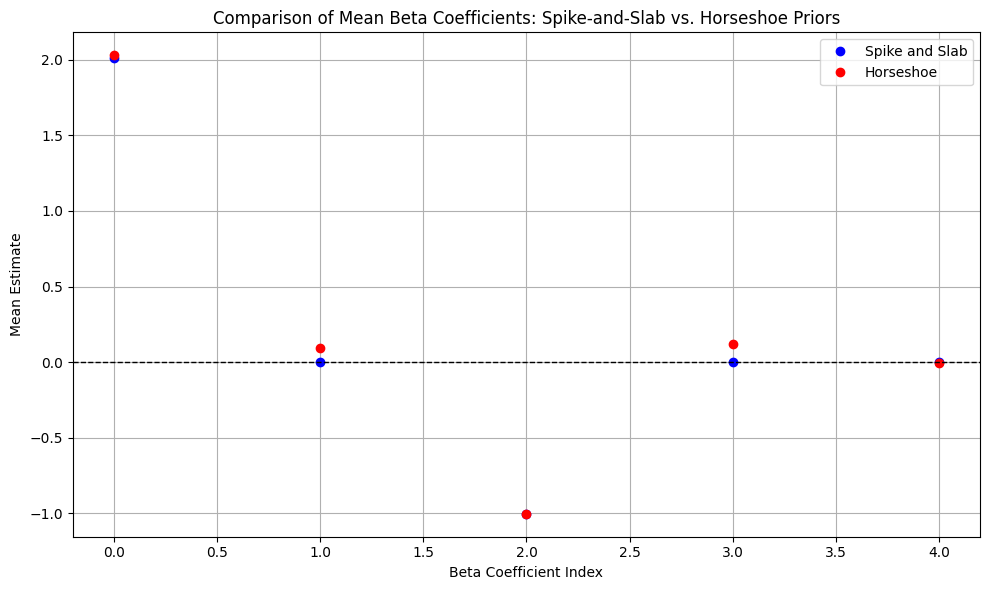

In [131]:
# Extract the beta coefficients' means from both models
beta_spike_slab_mean = idata.posterior['beta'].mean(dim=["chain", "draw"]).values
beta_horseshoe_mean = idata_horseshoe.posterior['beta'].mean(dim=["chain", "draw"]).values

# Create a plot
plt.figure(figsize=(10, 6))

# Plot for the spike-and-slab model
plt.plot(beta_spike_slab_mean, 'o', label="Spike and Slab", color='blue')

# Plot for the diffuse normal model
plt.plot(beta_horseshoe_mean, 'o', label="Horseshoe", color='red')

# Formatting the plot
plt.axhline(0, color='black', lw=1, linestyle='--')  # Zero line for reference
plt.xlabel('Beta Coefficient Index')
plt.ylabel('Mean Estimate')
plt.title('Comparison of Mean Beta Coefficients: Spike-and-Slab vs. Horseshoe Priors')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

The beta estimates for the two models were fairly similar. For each coefficient, the horseshoe prior adds a global scale (lambda) and a local scale (tau). This causes irrelevant or non-informative coefficients to shrink toward zero, but it does not require that they be precisely zero. This contrasts with the spike-and-slab prior, where the "spike" component serves as a sharp cutoff, increasing the likelihood that irrelevant coefficients will be exactly zero.
Irrelevant betas in the horseshoe prior are severely penalized toward smaller values. When working with high-dimensional data, where many features are not necessarily zero but contribute less to the result, this allows the horseshoe prior to model sparsity in the data without totally eliminating any coefficients.